In [1]:
import mkl
mkl.set_num_threads(1)
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np

from firesong.Firesong import firesong_simulation
from firesong.FluxPDF import flux_pdf
import pandas as pd
from os.path import join
import seaborn as sns
from astropy.cosmology import Planck18, z_at_value
import astropy.units as u
Planck18.luminosity_distance(0.3365) # TXS 0506+056

<Quantity 1830.08071709 Mpc>

# flux references

1.9905358527674847e-10
1.8e-08
1.892872033440579e-09


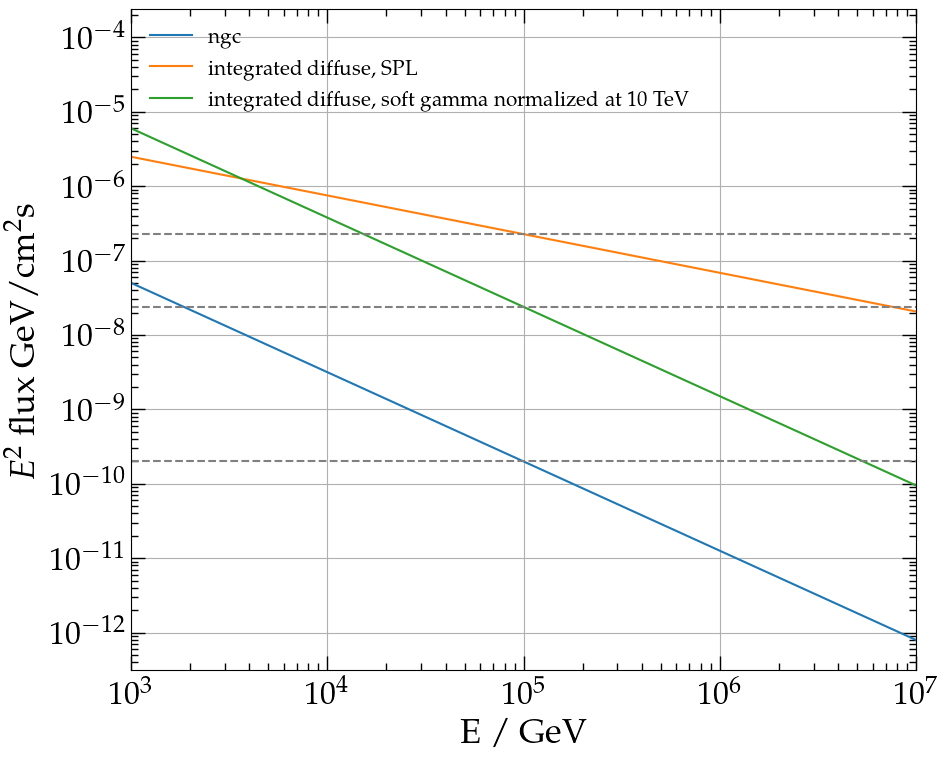

In [50]:
logE = np.linspace(2, 7)
E = 10**logE  # GeV
E0 = 1e3
gamma = 3.2
flux_ngc = lambda energy: 5e-14 * (energy / E0) ** -gamma  # / GeV cm^2 s
flux_diffuse = lambda energy: 1.8e-18 * (energy / 1e5) ** -2.52
flux_diffuse_soft = lambda energy: 3e-8 / (1e4**2) * (energy / 1e4) ** -3.2
_prefactor = 1  # 1E-3

plt.figure(figsize=(10, 8))

plt.loglog(E, _prefactor * (E**2) * flux_ngc(E), label="ngc")
plt.loglog(
    E,
    _prefactor * (E**2) * flux_diffuse(E) * 4 * np.pi,
    label="integrated diffuse, SPL",
)
plt.loglog(
    E,
    _prefactor * (E**2) * flux_diffuse_soft(E) * 4 * np.pi,
    label="integrated diffuse, soft gamma normalized at 10 TeV",
)

plt.grid()
plt.ylabel(r"$E^2$ flux  $ \rm GeV / cm^2 s $")
plt.xlabel(r"E / GeV")
plt.xlim(1e3, 1e7)
# plt.ylim(1e-14, 1.5e-9)
plt.legend(loc=2, bbox_to_anchor=(0, 1., 0, 0), frameon=False)

E_ref = 1e5

norm_ngc = (E_ref**2) * flux_ngc(E_ref)
norm_diffuse = (E_ref**2) * flux_diffuse(E_ref)
norm_diffuse_soft = (E_ref**2) * flux_diffuse_soft(E_ref)

plt.axhline(norm_ngc, color="gray", ls="--")
print(norm_ngc)
plt.axhline(norm_diffuse * 4 * np.pi, color="gray", ls="--")
print(norm_diffuse)
plt.axhline(norm_diffuse_soft * 4 * np.pi, color="gray", ls="--")
print(norm_diffuse_soft)

fluxnorm E^2 dPhi/dE = GeV s^-1 cm^-2 sr^-1 (default 1.44E-8)

total_flux: per steradian; flux per source: GeV s^-1 cm^-2

# load flux DP for NGC-like sources

In [3]:
BASEPATH = "/home/hpc/capn/capn102h/repos/Plenum"

In [4]:
ngc_flux_ps = pd.read_pickle(join("/home/hpc/capn/capn102h/repos/Plenum", "resources/flux_ngc_disc_pot.pickle"))
flux_agg = ngc_flux_ps.groupby("ident").aggregate({"disc5": ["min", "max", "mean"]})
flux_agg.columns = flux_agg.columns.droplevel()
flux_h = pd.DataFrame(ngc_flux_ps.groupby("ident").apply(
    lambda x: x.loc[np.isclose(x.dec, 0)]["disc5"]
))
flux_h.index = flux_h.index.droplevel(1)
flux_h.columns = ["horizon"]

flux_agg = pd.concat([flux_agg, flux_h], axis=1)

calc_E2norm = lambda E_ref, norm, gamma: (E_ref**2) * norm * (E_ref / E0) ** -gamma

# simulate various PDFs

In [5]:
from itertools import product

In [96]:
simPDF_ngc = {}
_kw = dict(
    outputdir=None,
    filename=None,
    index=3.2,
    Evolution="MD2014SFR",
    logFMin=-25,
    logFMax=0,
    emin=100,
    LumMin=1e40,
    LumMax=1e56,
    verbose=False,
    with_dFdz=True,
    nFluxBins=50,
)
_list = []
# densities = np.round(np.arange(5.0, 11.1, step=1), decimals=1)
# for indx, _width, _fluxref in product(densities, [1], [1, 0.1]):
#     # print(indx)
for _fluxref in [1, 0.1]:
    if _fluxref==1:
        densities = np.round(np.arange(5.0, 7.1, step=0.25), decimals=1)
    else:
        densities = np.round(np.arange(9.0, 12.1, step=0.5), decimals=1)
    for indx in densities:
        _tmp = flux_pdf(
            density=np.power(10, -indx),
            LF="SC", #"LG",
            # sigma=_width,
            fluxnorm=norm_diffuse_soft * _fluxref,
            **_kw
        )
        _list.append(
            pd.DataFrame(
                {
                    "Local source density": fr"$10^{{{-indx}}}$/Mpc",
                    "width": "SC",
                    "Total flux": _fluxref,
                    "flux": _tmp[0][::-1],
                    "Nsrc": _tmp[1][::-1],
                }
            )
        )
df = pd.concat(_list)
df["cumulative_Nsrc"] = df.groupby(["Local source density", "width", "Total flux"]).cumsum().Nsrc

# plots

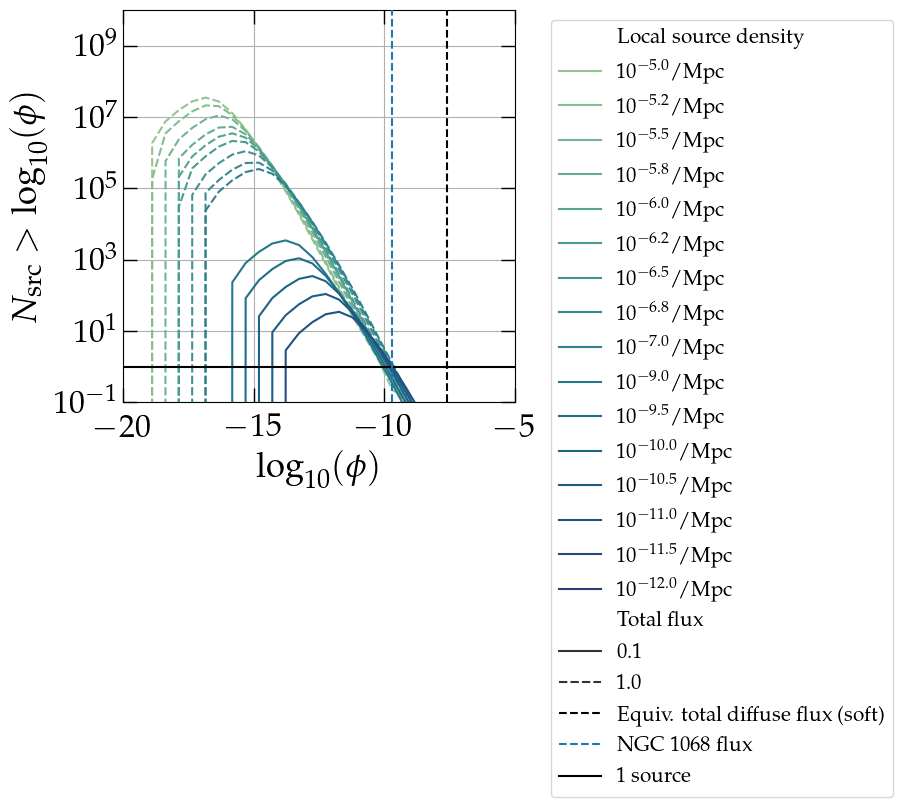

In [97]:
ax = sns.lineplot(
    data=df,
    x="flux",
    y="Nsrc",
    hue="Local source density",
    # size="width",
    style="Total flux",
    palette="crest",
)

plt.axvline(
    np.log10(norm_diffuse_soft * 4 * np.pi),
    color="k",
    ls="--",
    label="Equiv. total diffuse flux (soft)",
)
plt.axvline(
    np.log10(norm_ngc), ls="--", color="tab:blue", label="NGC 1068 flux", zorder=100
)


# for _l in flux_agg.values.flatten():
#     _flux = calc_E2norm(1e5, _l, 3.2)
#     plt.axvline(np.log10(_flux), lw=1, alpha=0.5, color="tomato")


plt.axhline(1, color="k", label="1 source")
plt.xlabel(r"$\log_{10}(\phi)$")
plt.ylabel(r"$N_{\rm src} > \log_{10}(\phi)$")
plt.legend(loc=1, bbox_to_anchor=(1, 0, 0.99, 1))
plt.xlim(-20, -5)
plt.ylim(1e-1, 1e10)
plt.yscale("log")
plt.grid(True)

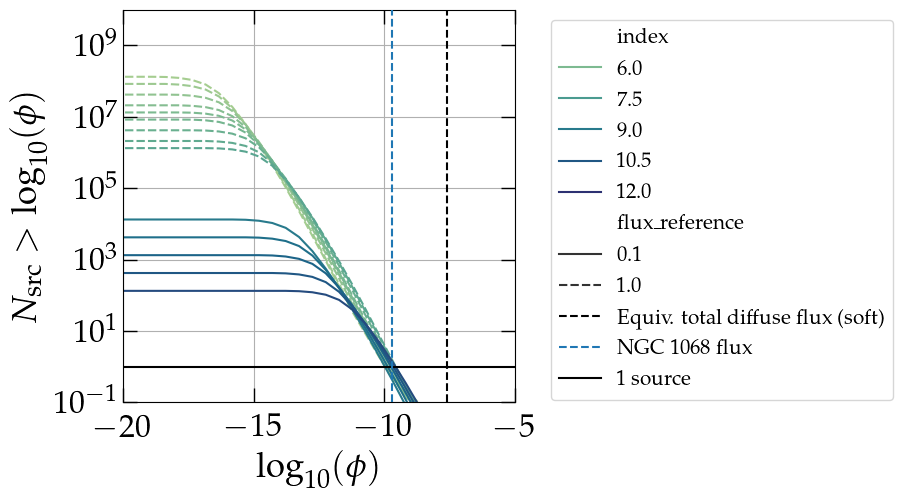

In [94]:
ax = sns.lineplot(
    data=df,
    x="flux",
    y="cumulative_Nsrc",
    hue="Local source density",
    # size="width",
    style="Total flux",
    palette="crest",
)

plt.axvline(
    np.log10(norm_diffuse_soft * 4 * np.pi),
    color="k",
    ls="--",
    label="Equiv. total diffuse flux (soft)",
)
plt.axvline(
    np.log10(norm_ngc), ls="--", color="tab:blue", label="NGC 1068 flux", zorder=100
)


# for _l in flux_agg.values.flatten():
#     _flux = calc_E2norm(1e5, _l, 3.2)
#     plt.axvline(np.log10(_flux), lw=1, alpha=0.5, color="tomato")


plt.axhline(1, color="k", label="1 source")
plt.xlabel(r"$\log_{10}(\phi)$")
plt.ylabel(r"$N_{\rm src} > \log_{10}(\phi)$")
plt.legend(loc=1, bbox_to_anchor=(1, 0, 0.99, 1))
plt.xlim(-20, -5)
plt.ylim(1e-1, 1e10)
plt.yscale("log")
plt.grid(True)

Text(0, 0.5, '$N_{\\rm src} > \\log_{10}(\\phi)$')

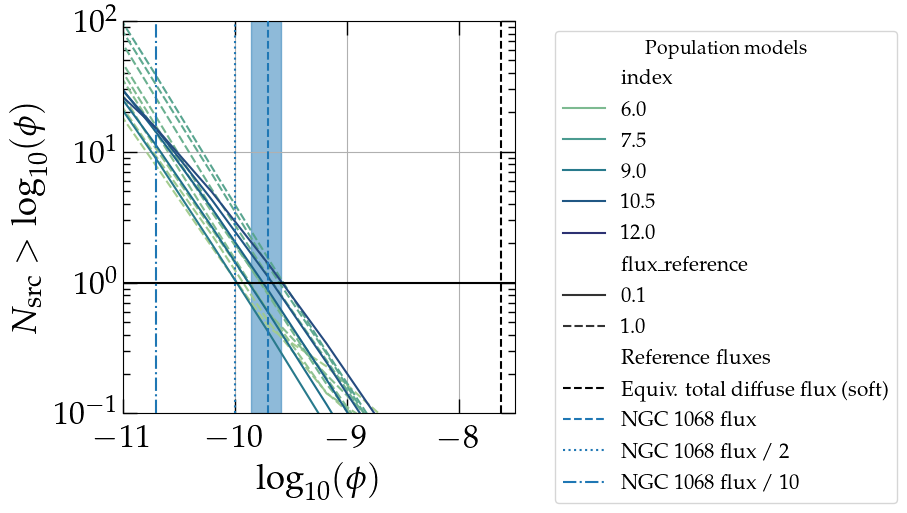

In [95]:
ax = sns.lineplot(
    data=df,
    x="flux",
    y="cumulative_Nsrc",
    hue="Local source density",
    # size="width",
    style="Total flux",
    palette="crest",
)

plt.axvspan(
    np.log10(norm_ngc / (5 / 3.5)),
    np.log10(norm_ngc / (5 / 6.5)),
    alpha=0.5,
    color="tab:blue",
)
plt.plot(np.nan, np.nan, label="Reference fluxes", color="w")
plt.axvline(
    np.log10(norm_diffuse_soft * 4 * np.pi),
    color="k",
    ls="--",
    label="Equiv. total diffuse flux (soft)",
)
plt.axvline(
    np.log10(norm_ngc), ls="--", color="tab:blue", label="NGC 1068 flux", zorder=100
)
plt.axvline(
    np.log10(norm_ngc/2), ls=":", color="tab:blue", label="NGC 1068 flux / 2", zorder=100
)
plt.axvline(
    np.log10(norm_ngc/10), ls="-.", color="tab:blue", label="NGC 1068 flux / 10", zorder=100
)
# for _l in flux_agg.values.flatten():
#     _flux = calc_E2norm(1e5, _l, 3.2)
#     plt.axvline(np.log10(_flux), lw=1, alpha=0.5, color="tomato")

plt.legend(loc=1, bbox_to_anchor=(1, 0, 1, 1), title="Population models")
plt.xlim(-11, -7.5)
plt.ylim(1e-1, 100)
plt.axhline(1, color="k")
plt.yscale("log")
plt.grid()
plt.xlabel(r"$\log_{10}(\phi)$")
plt.ylabel(r"$N_{\rm src} > \log_{10}(\phi)$")

In [87]:
from scipy.stats import poisson

In [72]:
poisson.pmf(1,4)

0.07326255555493673

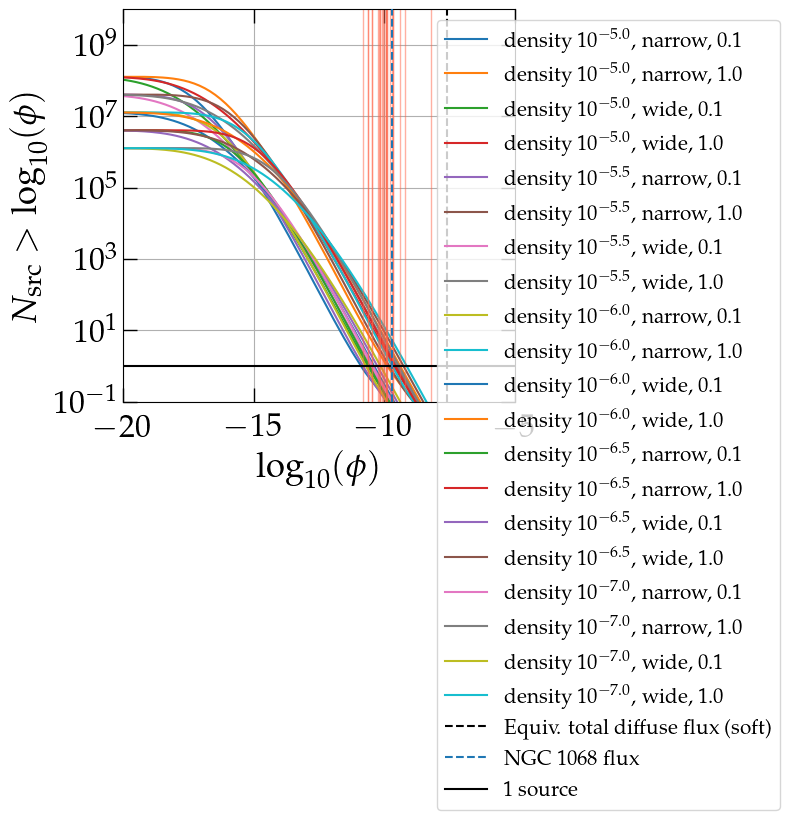

In [ ]:
for idx, series in df.groupby(["Local source density", "width", "Total flux"]):
    plt.plot(
        series.flux.values[0],
        np.cumsum(series.Nsrc.values[0][::-1])[::-1],
        label=rf"density $10^{{{-idx[0]}}}$, {idx[1]}, {idx[2]}",
    )
plt.axvline(
    np.log10(norm_diffuse_soft * 4 * np.pi),
    color="k",
    ls="--",
    label="Equiv. total diffuse flux (soft)",
)
plt.axvline(np.log10(norm_ngc), ls="--", color="tab:blue", label="NGC 1068 flux", zorder=100)


for _l in flux_agg.values.flatten():
    _flux = calc_E2norm(1e5, _l, 3.2)
    plt.axvline(np.log10(_flux), lw=1, alpha=0.5, color="tomato")


plt.axhline(1, color="k", label="1 source")
plt.xlabel(r"$\log_{10}(\phi)$")
plt.ylabel(r"$N_{\rm src} > \log_{10}(\phi)$")
plt.legend(loc=1, bbox_to_anchor=(1, 0, 0.7, 1))
plt.xlim(-20, -5)
plt.ylim(1e-1, 1e10)
plt.yscale("log")
plt.grid(True)

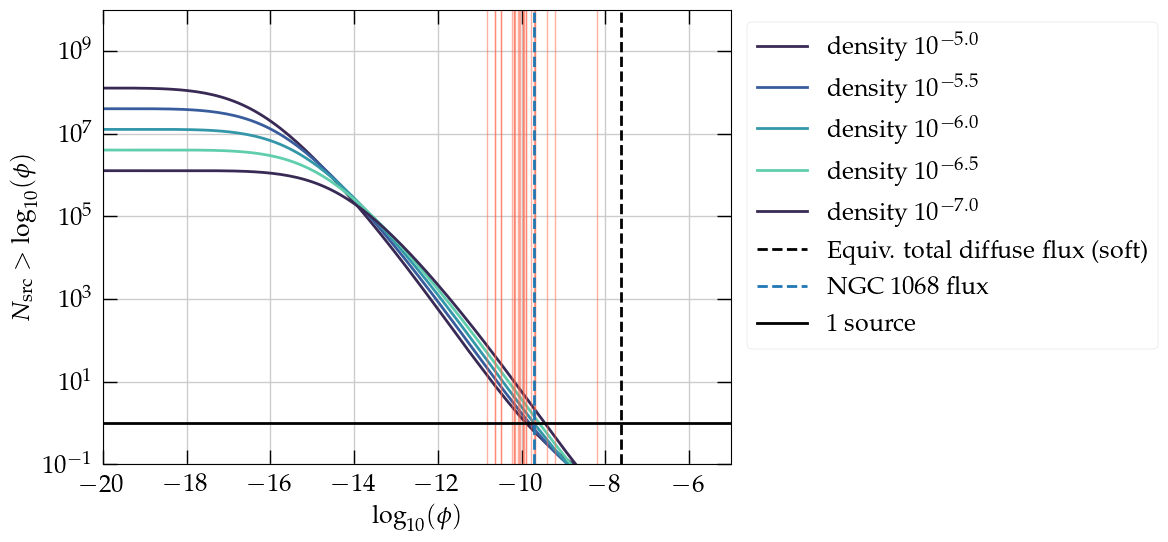

In [218]:
for indx in simPDF_ngc:

    plt.plot(
        simPDF_ngc[indx][0][0],
        np.cumsum(simPDF_ngc[indx][0][1][::-1])[::-1],
        label=rf"density $10^{{{-indx}}}$",
    )
plt.axvline(
    np.log10(norm_diffuse_soft * 4 * np.pi),
    color="k",
    ls="--",
    label="Equiv. total diffuse flux (soft)",
)
plt.axvline(np.log10(norm_ngc), ls="--", color="tab:blue", label="NGC 1068 flux", zorder=100)


for _l in flux_agg.values.flatten():
    _flux = calc_E2norm(1e5, _l, 3.2)
    plt.axvline(np.log10(_flux), lw=1, alpha=0.5, color="tomato")


plt.axhline(1, color="k", label="1 source")
plt.xlabel(r"$\log_{10}(\phi)$")
plt.ylabel(r"$N_{\rm src} > \log_{10}(\phi)$")
plt.legend(loc=1, bbox_to_anchor=(1, 0, 0.7, 1))
plt.xlim(-20, -5)
plt.ylim(1e-1, 1e10)
plt.yscale("log")
plt.grid(True)

Text(0, 0.5, '$N_{\\rm src} > \\log_{10}(\\phi)$')

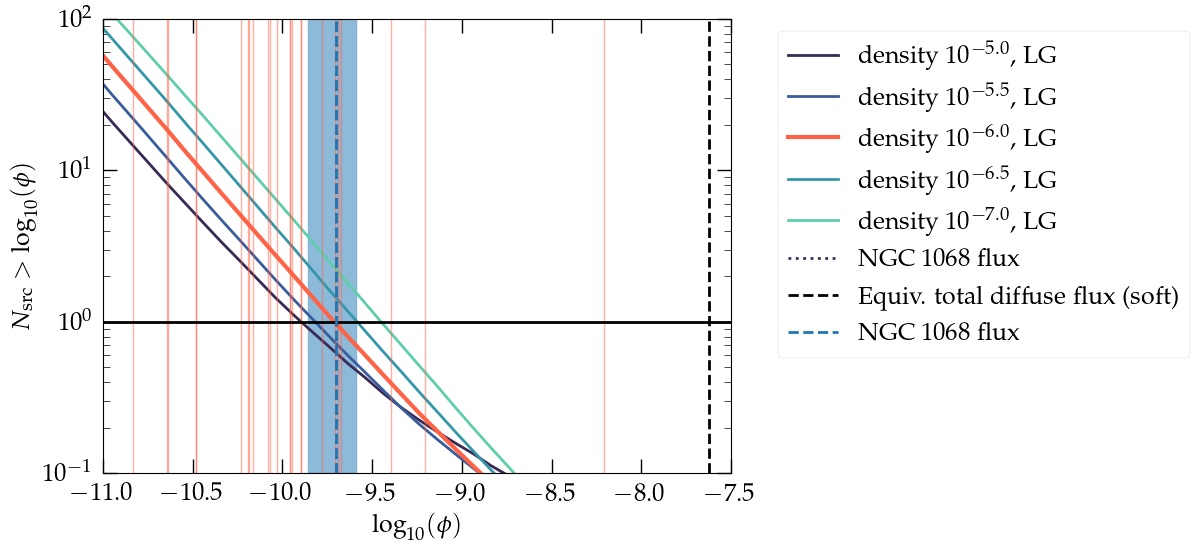

In [219]:
for indx in simPDF_ngc:
    if indx == 6:
        plt.plot(
            simPDF_ngc[indx][0][0],
            np.cumsum(simPDF_ngc[indx][0][1][::-1])[::-1],
            label=rf"density $10^{{{-indx}}}$, LG",
            color="tomato",
            lw=3,
        )
    else:
        p = plt.plot(
            simPDF_ngc[indx][0][0],
            np.cumsum(simPDF_ngc[indx][0][1][::-1])[::-1],
            label=rf"density $10^{{{-indx}}}$, LG",
        )

plt.axvline(np.log10(norm_ngc), ls=":", label="NGC 1068 flux")
plt.axvspan(
    np.log10(norm_ngc / (5 / 3.5)),
    np.log10(norm_ngc / (5 / 6.5)),
    alpha=0.5,
    color="tab:blue",
)

plt.axvline(
    np.log10(norm_diffuse_soft * 4 * np.pi),
    color="k",
    ls="--",
    label="Equiv. total diffuse flux (soft)",
)
plt.axvline(
    np.log10(norm_ngc), ls="--", color="tab:blue", label="NGC 1068 flux", zorder=100
)


for _l in flux_agg.values.flatten():
    _flux = calc_E2norm(1e5, _l, 3.2)
    plt.axvline(np.log10(_flux), lw=1, alpha=0.5, color="tomato")

plt.legend(loc=1, bbox_to_anchor=(1, 0, 0.75, 1))
plt.xlim(-11, -7.5)
plt.ylim(1e-1, 100)
plt.axhline(1, color="k")
plt.yscale("log")
plt.grid()
plt.xlabel(r"$\log_{10}(\phi)$")
plt.ylabel(r"$N_{\rm src} > \log_{10}(\phi)$")

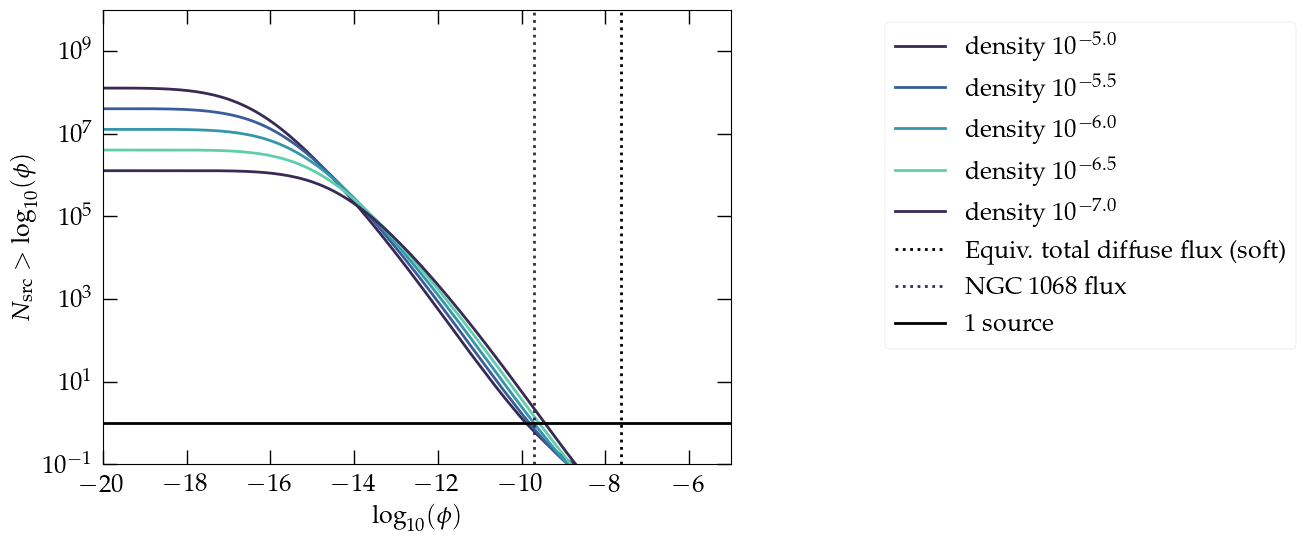

In [220]:
for indx in simPDF_ngc:

    plt.plot(
        simPDF_ngc[indx][0][0],
        np.cumsum(simPDF_ngc[indx][0][1][::-1])[::-1],
        label=rf"density $10^{{{-indx}}}$",
    )
plt.axvline(
    np.log10(norm_diffuse_soft * 4 * np.pi),
    color="k",
    ls=":",
    label="Equiv. total diffuse flux (soft)",
)
plt.axvline(np.log10(norm_ngc), ls=":", label="NGC 1068 flux")
plt.axhline(1, color="k", label="1 source")
plt.xlabel(r"$\log_{10}(\phi)$")
plt.ylabel(r"$N_{\rm src} > \log_{10}(\phi)$")
plt.legend(loc=1, bbox_to_anchor=(1, 0, 0.92, 1))
plt.xlim(-20, -5)
plt.ylim(1e-1, 1e10)
plt.yscale("log")
plt.grid()

5.0 1.7081021682972103e-09
5.5 1.7080374724901879e-09
6.0 1.7080078094578087e-09
6.5 1.708052164174115e-09
7.0 1.7081547361693805e-09


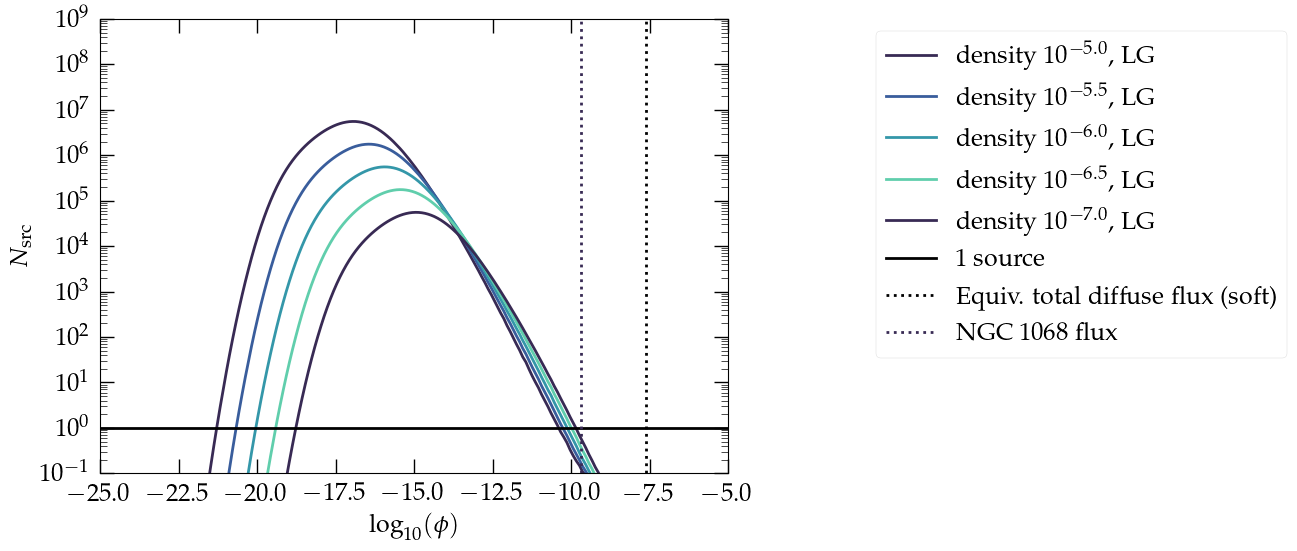

In [221]:
for indx in simPDF_ngc:

    print(
        indx,
        np.sum(simPDF_ngc[indx][0][1] * (10 ** simPDF_ngc[indx][0][0])) / 4 / np.pi,
    )
    # print(np.sum(simPDF_ngc[indx][1][1] * (10 ** simPDF_ngc[indx][1][0])) / 4 / np.pi)
    # print()
    p = plt.plot(
        simPDF_ngc[indx][0][0],
        simPDF_ngc[indx][0][1],
        ls="-",
        label=rf"density $10^{{{-indx}}}$, LG",
    )
    # plt.plot(
    #     simPDF_ngc[indx][1][0],
    #     simPDF_ngc[indx][1][1],
    #     label=rf"density $10^{{{-indx}}}$, SC",
    #     color=p[0].get_color(),
    # )
plt.xlim(-25, -5)
plt.ylim(1e-1, 1e9)
plt.axhline(1, color="k", label="1 source")
plt.axvline(
    np.log10(norm_diffuse_soft * 4 * np.pi),
    color="k",
    ls=":",
    label="Equiv. total diffuse flux (soft)",
)
plt.axvline(np.log10(norm_ngc), ls=":", label="NGC 1068 flux")
plt.yscale("log")
plt.grid()
plt.xlabel(r"$\log_{10}(\phi)$")
plt.ylabel(r"$N_{\rm src}$")
plt.legend(loc=1, bbox_to_anchor=(1, 0, 0.91, 1))

Text(0, 0.5, '$N_{\\rm src}$')

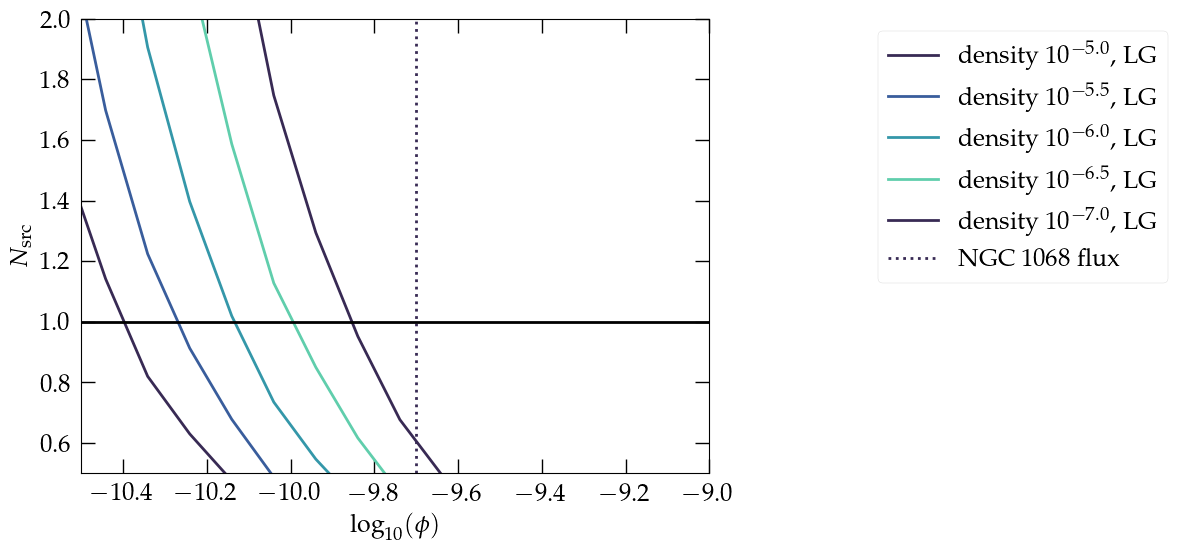

In [222]:
for indx in simPDF_ngc:

    p = plt.plot(
        simPDF_ngc[indx][0][0],
        simPDF_ngc[indx][0][1],
        label=rf"density $10^{{{-indx}}}$, LG",
    )
plt.axvline(np.log10(norm_ngc), ls=":", label="NGC 1068 flux")
plt.legend(loc=1, bbox_to_anchor=(1, 0, 0.75, 1))
plt.xlim(-10.5, -9)
plt.ylim(0.5, 2)
plt.axhline(1, color="k")
# plt.yscale("log")
plt.grid()
plt.xlabel(r"$\log_{10}(\phi)$")
plt.ylabel(r"$N_{\rm src}$")

[]

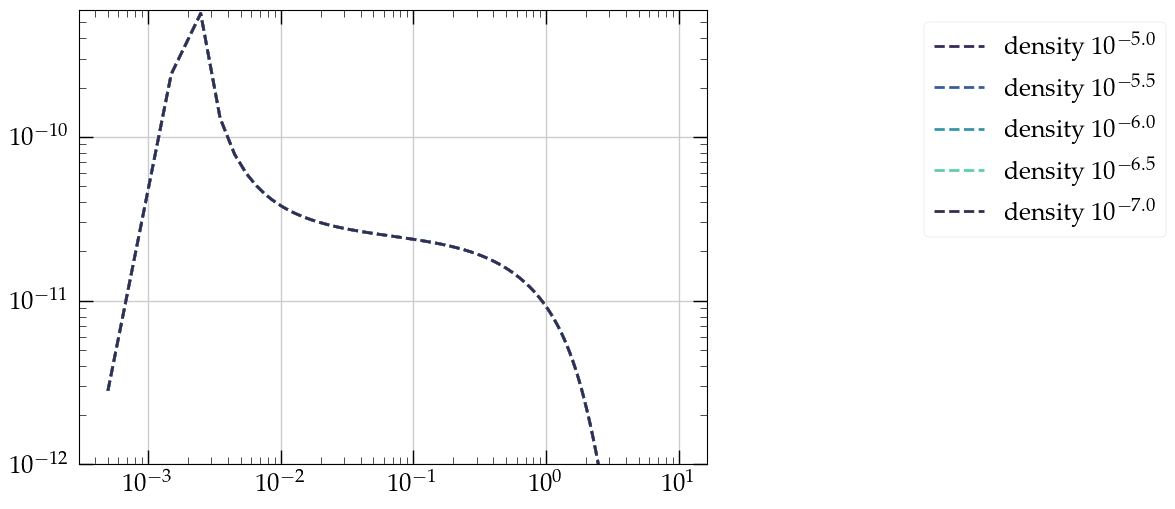

In [223]:
for indx in simPDF_ngc:

    p = plt.plot(
        simPDF_ngc[indx][0][2],
        simPDF_ngc[indx][0][3],
        ls="--",
        label=rf"density $10^{{{-indx}}}$",
    )
    # plt.plot(
    #     simPDF_ngc[indx][1][2],
    #     simPDF_ngc[indx][1][3],
    #     label=rf"density $10^{{{-indx}}}$, SC",
    #     color=p[0].get_color(),
    # )


plt.legend(loc=1, bbox_to_anchor=(1, 0, 0.75, 1))
# plt.xlim(-20, 0)
plt.ylim(1E-12, None)
# plt.yscale("log")
plt.loglog()

In [224]:
for indx in simPDF_ngc:

    p = plt.plot(
        simPDF_ngc[indx][0][2],
        simPDF_ngc[indx][0][3]/simPDF_ngc[indx][1][3],
        label=rf"density $10^{{{-indx}}}$",
    )

plt.legend(loc=1, bbox_to_anchor=(1, 0, 0.75, 1))
# plt.xlim(-20, 0)
# plt.ylim(1E-12, None)
# plt.yscale("log")
# plt.loglog()

TypeError: 'int' object is not subscriptable

# sandbox

In [22]:
z_at_value(Planck18.comoving_distance, 1830 * u.Mpc)

<Quantity 0.46570797 redshift>

In [ ]:
z_at_value(Planck18.luminosity_distance, 1830 * u.Mpc)

<Quantity 0.33648722 redshift>

In [ ]:
z_at_value(Planck18.luminosity_distance, 14.4 * u.Mpc)

<Quantity 0.0032524 redshift>

In [82]:
sim1 = firesong_simulation(
    None,
    filename=None,
    density=1e-8,
    fluxnorm=1e-8,
    index=2,
    Evolution="MD2014SFR",
    LF="SC",
    verbose=False,
)

sim2 = firesong_simulation(
    None,
    filename=None,
    density=1e-8,
    fluxnorm=1e-8,
    index=3,
    Evolution="MD2014SFR",
    LF="SC",
    verbose=False,
)

(array([1.005e+03, 1.176e+03, 1.484e+03, 1.821e+03, 2.335e+03, 2.779e+03,
        3.364e+03, 4.051e+03, 4.784e+03, 5.781e+03, 6.538e+03, 7.331e+03,
        8.219e+03, 8.747e+03, 9.107e+03, 9.343e+03, 8.899e+03, 8.327e+03,
        7.613e+03, 6.513e+03, 5.436e+03, 4.339e+03, 3.445e+03, 2.647e+03,
        2.087e+03, 1.580e+03, 1.196e+03, 8.140e+02, 6.400e+02, 4.640e+02,
        2.960e+02, 2.360e+02, 1.740e+02, 1.240e+02, 6.800e+01, 6.200e+01,
        4.100e+01, 2.900e+01, 1.900e+01, 1.100e+01, 7.000e+00, 5.000e+00,
        3.000e+00, 4.000e+00, 1.000e+00, 1.000e+00, 2.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00]),
 array([-14.71884976, -14.59182862, -14.46480747, -14.33778632,
        -14.21076517, -14.08374402, -13.95672287, -13.82970172,
        -13.70268057, -13.57565942, -13.44863827, -13.32161712,
        -13.19459598, -13.06757483, -12.94055368, -12.81353253,
        -12.68651138, -12.55949023, -12.43246908, -12.30544793,
        -12.17842678, -12.05140563, -11.92438448, -11.79

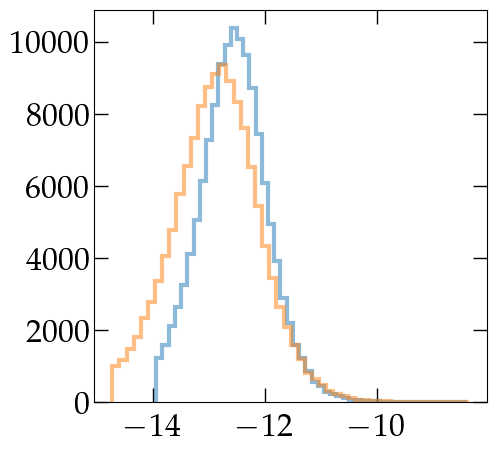

In [83]:
plt.hist(
    np.log10(sim1["sources"]["flux"]),
    bins=50,
    alpha=0.5,
    label="gamma=2",
    lw=3,
    histtype="step",
)
plt.hist(
    np.log10(sim2["sources"]["flux"]),
    bins=50,
    alpha=0.5,
    label="gamma=3",
    lw=3,
    histtype="step",
)

In [10]:
_lf = "LG"
sim1 = firesong_simulation(
    None,
    filename=None,
    density=1e-8,
    fluxnorm=1e-8,
    index=2,
    Evolution="NoEvolution",
    LF=_lf,
    verbose=False,
)

sim2 = firesong_simulation(
    None,
    filename=None,
    density=1e-7,
    fluxnorm=1e-8,
    index=2,
    Evolution="NoEvolution",
    LF=_lf,
    verbose=False,
)

sim3 = firesong_simulation(
    None,
    filename=None,
    density=1e-7,
    fluxnorm=0.5e-8,
    index=2,
    Evolution="NoEvolution",
    LF=_lf,
    verbose=False,
)

sim4 = firesong_simulation(
    None,
    filename=None,
    density=1e-8,
    fluxnorm=0.5e-8,
    index=2,
    Evolution="NoEvolution",
    LF=_lf,
    verbose=False,
)

In [11]:
sim1["total_flux"], sim2["total_flux"], sim3["total_flux"]

(7.155858587973778e-09, 8.655360747598553e-09, 4.606802307967908e-09)

In [12]:
np.sum(sim1["sources"]["flux"]), np.sum(sim2["sources"]["flux"]), np.sum(sim3["sources"]["flux"]), np.sum(sim2["sources"]["flux"]) / np.sum(sim3["sources"]["flux"])

(8.992317108042341e-08,
 1.087664709553003e-07,
 5.7890785149009936e-08,
 1.8788218310623561)

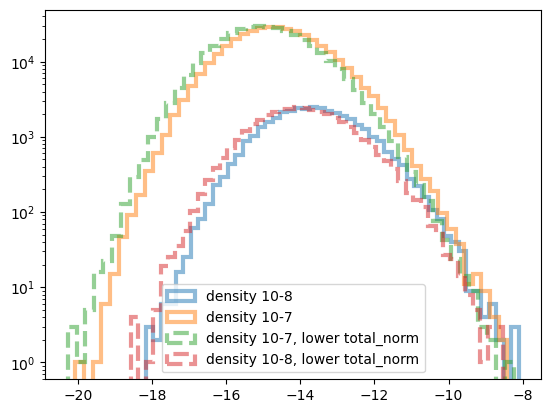

In [13]:
plt.hist(
    np.log10(sim1["sources"]["flux"]),
    bins=50,
    alpha=0.5,
    label="density 10-8",
    lw=3,
    histtype="step",
)
plt.hist(
    np.log10(sim2["sources"]["flux"]),
    bins=50,
    alpha=0.5,
    label="density 10-7",
    lw=3,
    histtype="step",
)
plt.hist(
    np.log10(sim3["sources"]["flux"]),
    bins=50,
    alpha=0.5,
    label="density 10-7, lower total_norm",
    lw=3,
    histtype="step",
    ls="--",
)
plt.hist(
    np.log10(sim4["sources"]["flux"]),
    bins=50,
    alpha=0.5,
    label="density 10-8, lower total_norm",
    lw=3,
    histtype="step",
    ls="--",
)
plt.yscale("log")
plt.legend()

In [14]:
import seaborn as sns

/home/hpc/capn/capn102h/miniconda3/envs/plenum/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/hpc/capn/capn102h/miniconda3/envs/plenum/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/hpc/capn/capn102h/miniconda3/envs/plenum/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/hpc/capn/capn102h/miniconda3/envs/plenum/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_in

<Axes: >

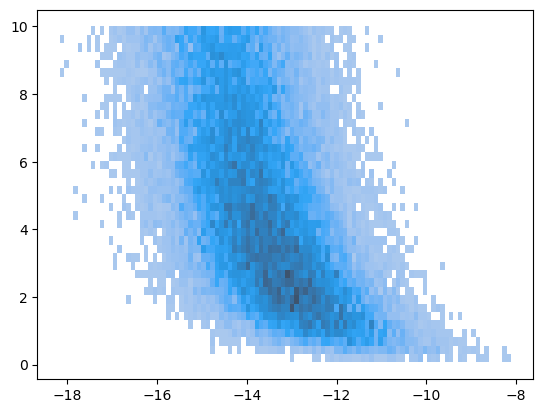

In [15]:
sns.histplot(
    x=np.log10(sim1["sources"]["flux"]),
    y=sim1["sources"]["z"],
)


/home/hpc/capn/capn102h/miniconda3/envs/plenum/lib/python3.11/site-packages/IPython/core/events.py:93: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/hpc/capn/capn102h/miniconda3/envs/plenum/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


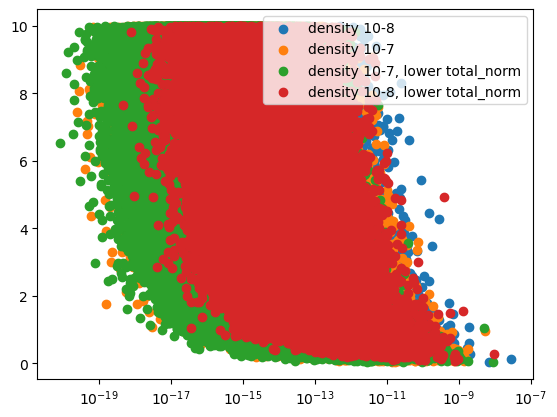

In [ ]:
plt.scatter(
    sim1["sources"]["flux"],
    sim1["sources"]["z"],
    label="density 10-8",
)
plt.scatter(
    sim2["sources"]["flux"],
    sim2["sources"]["z"],
    label="density 10-7",
)
plt.scatter(
    sim3["sources"]["flux"],
    sim3["sources"]["z"],
    label="density 10-7, lower total_norm",
)
plt.scatter(
    sim4["sources"]["flux"],
    sim4["sources"]["z"],
    label="density 10-8, lower total_norm",
)
plt.xscale("log")
plt.legend()

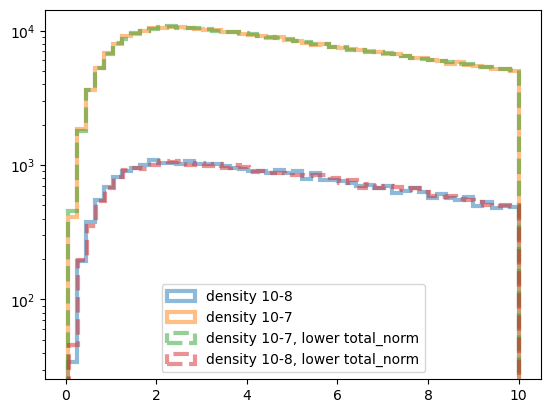

In [23]:
plt.hist(
    sim1["sources"]["z"],
    bins=50,
    alpha=0.5,
    label="density 10-8",
    lw=3,
    histtype="step",
)
plt.hist(
    sim2["sources"]["z"],
    bins=50,
    alpha=0.5,
    label="density 10-7",
    lw=3,
    histtype="step",
)
plt.hist(
    sim3["sources"]["z"],
    bins=50,
    alpha=0.5,
    label="density 10-7, lower total_norm",
    lw=3,
    histtype="step",
    ls="--",
)
plt.hist(
    sim4["sources"]["z"],
    bins=50,
    alpha=0.5,
    label="density 10-8, lower total_norm",
    lw=3,
    histtype="step",
    ls="--",
)
plt.yscale("log")
plt.legend()